# Создание даталоудеров и функции создания  графиков и гистограмм

In [5]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
#from sklearn.metrics import r2_score
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
print(device)
%matplotlib inline
np.random.seed(1)
plt.style.use("seaborn-talk") #"classic" "seaborn-talk" "seaborn"
path_to_h5 =  "/home/leonov/Baikal/Gr_big_data/mc_baikal_norm_cut-8_ordered_with_MCarlo.h5"
ONES_torch = torch.ones(128).to(device)
# Создание даталоудеров
def make_set(i, di = 1, tr_set_len = 128,Batch_size = 64,regime = "train"):
    with h5py.File(path_to_h5, 'r') as hf:
            Data = hf[regime + '/data/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),:32]
            Polar=hf[regime + "/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),0]*(np.pi)/180
            Azimut=hf[regime + "/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),1]*(np.pi)/180
            x=np.expand_dims(np.sin(Polar)*np.cos(Azimut),axis=1)
            y=np.expand_dims(np.sin(Polar)*np.sin(Azimut),axis=1)
            z=np.expand_dims(np.cos(Polar),axis=1)
            target=torch.FloatTensor(np.concatenate((x,y,z) ,axis=1))
            Data = torch.FloatTensor(Data.swapaxes(1, -1)) # надо,т.к. второй индекс должен быть количеством   последовательностей
            Dataset = torch.utils.data.TensorDataset(Data, target)
            Loader = torch.utils.data.DataLoader(dataset = Dataset, batch_size=Batch_size, drop_last = True) #,sampler = sampler    
    return Loader

# вектора в углы
ONES_torch = torch.ones(64).to(device)
def v_to_angles( Predicted, Real,
                p_hist, az_hist, 
                p_error_hist_az,
                p_error_hist,p_error_angle_cut_hist,I_want_scatter_plot = False,
                min_angle = 10., max_angle = 60.): 
    v_pred = torch.nn.functional.normalize(Predicted.detach()) # нормализую
    polar_real = torch.acos(torch.minimum(Real[:,-1],ONES_torch) )/(np.pi)*180 
    polar_predicted = torch.acos(torch.minimum(v_pred[:,-1],ONES_torch) )/(np.pi)*180 
    # azimut pred
    azimut =torch.acos( v_pred[:,0]/((v_pred[:,0])**2+(v_pred[:,1])**2+1e-8)**0.5 ) # добавляю  в знаменатель добавку чтоб наны не получить
    azimut = azimut+(torch.sign(v_pred[:,1])**2)*(1-torch.sign(v_pred[:,1]))*(np.pi-azimut) # torch.sign(v[:,1])**2 на случай нулевых углов,которых нет    
    # azimut_real
    azimut_real =torch.acos( Real[:,0]/((Real[:,0])**2+(Real[:,1])**2+1e-8)**0.5 ) # добавляю  в знаменатель добавку чтоб наны не получить
    azimut_real = azimut_real+(torch.sign(Real[:,1])**2)*(1-torch.sign(Real[:,1]))*(np.pi-azimut_real) # torch.sign(v[:,1])**2 на случай нулевых углов,которых нет
    azimut_real = azimut_real/(np.pi)*180 # привожу к градусам
    azimut = azimut/(np.pi)*180 # привожу к градусам
    if I_want_scatter_plot:
        plt.subplot(2, 1, 1)
        plt.scatter(polar_real.cpu().detach().numpy(),polar_predicted.cpu().detach().numpy(), s=1 ,color = "blue",alpha =0.3 )
        plt.xlabel("Real polar angle", fontsize = 17);plt.ylabel("Predicted polar angle", fontsize = 17)
        plt.title("Scatter plot for polar angle", fontsize = 26)
        plt.subplot(2, 1, 2)
        plt.scatter(azimut_real.cpu().detach().numpy(),azimut.cpu().detach().numpy(), s=1 ,color = "blue",alpha =0.2 )
        plt.xlabel("Real azimut angle", fontsize = 17);plt.ylabel("Predicted azimut angle", fontsize = 17)
        plt.title("Scatter plot for azimut angle", fontsize = 26) 
    azimut = azimut.short()
    for pol_pred, pol_real in zip(polar_predicted, polar_real):
        p_error_hist[round(abs((pol_pred-pol_real).item()),1)] += 1
        # for certain angles !!!!!!!!!!!!!!!!!!!!!!!
        if (pol_real.item() >= min_angle) and (pol_real.item() <= max_angle): 
            p_error_angle_cut_hist[round(abs((pol_pred-pol_real).item()),1)] += 1        
        p_hist[pol_pred.short().item()] += 1
        #az_hist[az.item()] += 1
    for az_pred, az_real in zip(azimut, azimut_real): 
        er = abs((az_pred-az_real).item())
        er= min(360-er, er)
        p_error_hist_az[round(er,1)] += 1
        az_hist[az_pred.item()] += 1

def resolution_calculation(Predicted,Real,
                           hist,hist_angle_cut,
                           min_angle = 10., max_angle = 60.
                          ):
    #res = torch.acos(torch.nn.functional.cosine_similarity(Predicted,Real,dim = 1))/np.pi*180
    res = torch.nn.functional.cosine_similarity(Predicted,Real,dim = 1)
    res = torch.acos(torch.minimum(res, ONES_torch))/np.pi*180
    polar_real = torch.acos(torch.minimum(Real[:,-1], ONES_torch))/(np.pi)*180  # для сравнения
    for i,res_value in enumerate(res):
        try:
            hist[round(res_value.item(),1)] += 1
            if (polar_real[i].item() >= min_angle) and (polar_real[i].item() <= max_angle) :
                hist_angle_cut[round(res_value.item(),1)] += 1
        except KeyError:
            hist[0.0] += 1
            print(res_value.item(),"torch is bad at acos calculation")
def loss_plot(list_test, list_train , path , save = True):
    plt.figure(figsize=(9,6))
    plt.plot(np.arange(len(list_test)), list_test, label='val', linewidth=2)
    plt.plot(np.arange(len(list_train)), list_train, label='train', linewidth=2)
    plt.title('Loss_plot')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend(fontsize =12)
    if save == True:
        plt.savefig(path)
    plt.show()
def res_plot(train_dict,val_dict, path = None,save = True, res_or_polar = "Resolution " ,size= 13):
    plt.figure(figsize=(13,5))
    colours=["red","red"]
    names = ["train" , "val"]
    for i, d in enumerate([train_dict,val_dict]):
        plt.subplot(1,2,i+1)
        s = sum(d.values())
        prep_inter_s ,inter_s = 0, 0
        res_50, res_68 =0,0
        for key in list(d.keys()):
            if inter_s/s >= 0.68:
                alpha = (inter_s-0.68*s)/(inter_s-prep_inter_s) # alpha*inter_s+(1-alpha)*prep_inter_s == 0.68*s
                res_68 =round(key + 0.1*alpha,2)  #alpha*(key-0.1)+(1-alpha)*(key)
                break
            if inter_s/s >= 0.5 and res_50 == 0:
                alpha = (inter_s-0.5*s)/(inter_s-prep_inter_s)
                res_50 =round(key + 0.1*alpha,2)
            prep_inter_s = inter_s 
            inter_s  += d[key]  
        a=plt.step(list(d.keys())[:300], list(d.values())[:300], color=colours[i],alpha = 0.6)
        plt.bar(res_50, max(d.values()), width=0.5,label=names[i] + "50%" + res_or_polar +"= "+str(res_50),
                color="yellow" , alpha =0.7 )
        plt.bar(res_68, max(d.values()), width=0.5,label=names[i] + "68%" + res_or_polar +" = "+str(res_68) ,
                color="orange",alpha = 0.7)
        plt.legend(fontsize= 12)#; plt.suptitle(res_or_polar,fontsize =size+3)
        plt.xlabel(res_or_polar + "in_grad",fontsize= 16); plt.title(res_or_polar + names[i],fontsize= 22)
    if save == True:
        plt.savefig(path) 
    plt.show()

def angle_hist(hist_polar,hist_azimut,path, save =True,size= 20,name = "train"):
    with h5py.File(path_to_h5, 'r') as hf:
        plt.figure(figsize= (13,18))
        sum_value = sum(hist_polar.values())
        Polar=hf["/"+name+"/ev_chars"][ : ,0] 
        Azimut=hf["/"+name+"/ev_chars"][ : ,1]
        plt.subplot(2,1,1)
        plt.hist(Polar,bins=180,label="Real polar angle in " + name +" data",density=True,histtype="step",color="blue")
        plt.bar(list(hist_polar.keys())[:100], np.array(list(hist_polar.values())[:100])/sum_value, 
                color="red",label="Predicted polar angle in " + name +" data")
        plt.legend(fontsize = 18)
        plt.xlabel("Polar Angle",fontsize= 25); plt.title(name+"_Polar",fontsize= 30)
        plt.subplot(2,1,2) 
        plt.hist(Azimut,bins=360,label="Real azimut angle in " + name +" data",density=True,histtype="step",color="blue")
        plt.bar(list(hist_azimut.keys()), np.array(list(hist_azimut.values()))/sum_value,
                    align = 'center', color="red",label="Predicted azimut angle in " + name +" data")
        plt.legend(fontsize = 18)
        plt.xlabel("Azimut Angle",fontsize= 25) ;plt.title(name+" Azimut angle",fontsize= 30)
        if save == True:
            plt.savefig(path) 
        plt.show()


cuda:0


# Обучение

In [2]:
def fitting(model, scheduler_Exp, scheduler_MultiStep , optimizer,
        min_angle = 10. ,max_angle = 60.0,
        epochs_num = 25, batch_size = 64,
        criterion=torch.nn.L1Loss(),
        save_weights = True, save_plot = True, save_resolution = True,  save_angles = True, save_polar_error = True, 
        save_az_error = True,
        suffix = "Nu_MAE_Only_Polar_MC_DATA_DIRECTION",
        path_begin = "/home/leonov/Baikal/Gr_big_data"
           ):
    tr_set_len = 2*512*100
    seq = [j for j in range(int( 1365465/tr_set_len))]
    #print('Num of sub-epochs in Epoch = ', len(seq), '\n')
    len_seq = len(seq)
    loss_train = []
    loss_test = []
    
    # здесь будут polar error всех событий
    hist_train_polar_error = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    
    # здесь будут azimut error всех событий
    hist_train_azimut_error = {round(k,1):0 for k in np.arange(0.0, 181., 0.1)} 
    hist_val_azimut_error = {round(k,1):0 for k in np.arange(0.0, 181., 0.1)}    
    
    # здесь будут polar error углов от min_angle до max_angle
    hist_train_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    
    # здесь будут гистограммы  разрешения всех событий
    hist_train_res = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    hist_val_res = {round(k,1):0 for k in np.arange(0.0, 180, 0.1)}
    
    # здесь будут гистограммы  разрешения от min_angle до max_angle
    hist_train_res_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    hist_val_res_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    
    # гистограммы  предсказанных углов для сравнения с реальным распределением     
    hist_train_polar = {k:0 for k in np.arange(0, 181, 1)}
    hist_train_azimut = {k:0 for k in np.arange(0, 361, 1)}
    hist_val_polar = {k:0 for k in np.arange(0, 181, 1)} 
    hist_val_azimut = {k:0 for k in np.arange(0, 361, 1)} 
    
    num = 0
    for n in range(1, epochs_num+1):
        #training
        print('Indeed Epoch = ', n, end = "  ")
        for i in seq:
            train_Loader = make_set(i,1,tr_set_len,Batch_size = batch_size)
            for x_batch,y_batch in train_Loader:
                optimizer.zero_grad()
                outp = model(x_batch.to(device).float())
                loss =   criterion(outp,y_batch.to(device).float())
                loss.backward()
                optimizer.step()
                # полученный вектор направления превращаю в углы и добавляю в гистограммы
                if n == epochs_num:
                    v_to_angles(Predicted = outp, Real = y_batch.to(device),
                                p_error_hist_az = hist_train_azimut_error,
                                p_error_hist = hist_train_polar_error,
                                p_error_angle_cut_hist = hist_train_polar_error_angle_cut,
                                p_hist = hist_train_polar, az_hist = hist_train_azimut,
                                min_angle = min_angle, max_angle = max_angle)
                    resolution_calculation(outp,y_batch.to(device),
                                           min_angle = min_angle ,max_angle = max_angle,
                                           hist = hist_train_res,
                                           hist_angle_cut = hist_train_res_angle_cut  )
            if (num%(len_seq//3) == 0):
                #rand_ind=np.random.randint(0,15)
                #print('Sub-epoch number = ', num)
                loss_train.append(loss.item())
                model.eval()
                testLoader = make_set(0,-1,1, Batch_size = batch_size, regime = "val")
                test_loss=0
                count=0
                for x_test_batch,y_test_batch in testLoader:
                    outp = model(x_test_batch.to(device).float())
                    test_loss +=  criterion(outp,y_test_batch.to(device).float()).item()
                    count+=1
                test_loss /=count
                loss_test.append(test_loss)
                model.train()
                #print("train_loss = ",loss.item(),"  val_loss = ",test_loss)
            num+=1
        scheduler_Exp.step()
        scheduler_MultiStep.step()
    # гистограммы для val датасета     
    model.eval()
    FinalLoader = make_set(0,-1,1, Batch_size = batch_size, regime = "val") # делаю  loader из всего датасета
    plt.figure(figsize=(8,16))
    for x_test_batch,y_test_batch in FinalLoader:
        outp = model(x_test_batch.to(device).float())
        v_to_angles(Predicted = outp, Real = y_test_batch.to(device), I_want_scatter_plot = True,
                    p_error_hist_az = hist_val_azimut_error,
                    p_error_hist = hist_val_polar_error,
                    p_error_angle_cut_hist = hist_val_polar_error_angle_cut,
                    p_hist = hist_val_polar, az_hist = hist_val_azimut,
                    min_angle = min_angle, max_angle = max_angle)
        resolution_calculation(outp, y_test_batch.to(device),
                               min_angle = min_angle ,max_angle = max_angle,
                               hist = hist_val_res,
                               hist_angle_cut = hist_val_res_angle_cut )
        
    if save_weights == True:
        torch.save(model.state_dict(), path_begin + "/states/" + suffix + "model")
        torch.save(optimizer.state_dict(), path_begin + "/states/" + suffix + "opt")
        
    # график лосса
    loss_plot(list_test = loss_test, list_train = loss_train ,path = path_begin + "/Images/Loss/" + suffix + "LOSS.png", 
      save = save_plot )
    
    #  гистограмма ошибок  полярного угла
    res_plot(hist_train_polar_error, hist_val_polar_error, 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Polar_Error.png",
             save = save_polar_error, res_or_polar = "Polar_Error ")
    
    #  гистограмма ошибок  azimut угла
    res_plot(hist_train_azimut_error, hist_val_azimut_error, 
             path = path_begin + "/Images/Azimut_Error/" + suffix+ "Azimut_Error.png",
             save = save_az_error, res_or_polar = "Azimut_Error ")    
 
    #  гистограмма ошибок  полярного угла для определенных углов
    res_plot(hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut, 
             path = path_begin + "/Images/Polar_Error_Angle_Cut/" + suffix+ "Polar_Error_Angle_Cut.png",
             save = save_polar_error, res_or_polar = "Polar_Error_Angle_Cut ")  
    
    # гистограммы разрешения
    res_plot(hist_train_res,hist_val_res,
             path = path_begin + "/Images/Resolution/" + suffix + "RESOLUTIONS.png",
             save = save_resolution,res_or_polar = "Resolution ")
    
    # гистограммы разрешения для определенных углов
    res_plot(hist_train_res_angle_cut,hist_val_res_angle_cut,
             path = path_begin + "/Images/Resolution_Angle_Cut/" + suffix + "Resolution_Angle_Cut.png",
             save = save_resolution,res_or_polar = "Resolution_Angle_Cut ")
    
    #гистограммы углов
    angle_hist(hist_train_polar,hist_train_azimut, name='train',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_train.png", 
               save = save_angles)
    angle_hist(hist_val_polar,hist_val_azimut, name='val',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_val.png", 
               save = save_angles)
    
    loss_lists = [loss_train , loss_test]
    polar_hists = [hist_train_polar , hist_val_polar]
    azimut_hists = [hist_train_azimut, hist_val_azimut]
    res_hists = [hist_train_res, hist_val_res,
                 hist_train_res_angle_cut, hist_val_res_angle_cut]
    polar_error = [hist_train_polar_error, hist_val_polar_error,
                   hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut
                  ]
    model.train()
    return  loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error
############################################################################################################




# Сеть

In [3]:
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 ),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 


power = 4
bias_mask = False
class ResNet_Block_power(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power,input_size,  kernel_size=3, stride= 1 ,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias =  bias_mask),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
a = torch.ones((512,5 ,32))
much_bigger_net_4 = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ,bias = bias_mask),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block_power(5), #32
    ResNet_Block_power(5), 
    Transition_Block(5), #16
    ResNet_Block_power(10),
    ResNet_Block_power(10), #16
    Transition_Block(10), #8
    ResNet_Block_power(20),
    ResNet_Block_power(20), 
    Transition_Block(20), #4
    ResNet_Block_power(40),
    ResNet_Block_power(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160 ,3)
) 


print(much_bigger_net_4(a).shape )
sum(p.numel() for p in much_bigger_net_4.parameters()   )




torch.Size([512, 3])


369076

# Результаты

Indeed Epoch =  1  Indeed Epoch =  2  Indeed Epoch =  3  Indeed Epoch =  4  Indeed Epoch =  5  Indeed Epoch =  6  Indeed Epoch =  7  Indeed Epoch =  8  Indeed Epoch =  9  Indeed Epoch =  10  Indeed Epoch =  11  Indeed Epoch =  12  Indeed Epoch =  13  Indeed Epoch =  14  Indeed Epoch =  15  Indeed Epoch =  16  Indeed Epoch =  17  Indeed Epoch =  18  Indeed Epoch =  19  Indeed Epoch =  20  Indeed Epoch =  21  Indeed Epoch =  22  Indeed Epoch =  23  Indeed Epoch =  24  Indeed Epoch =  25  

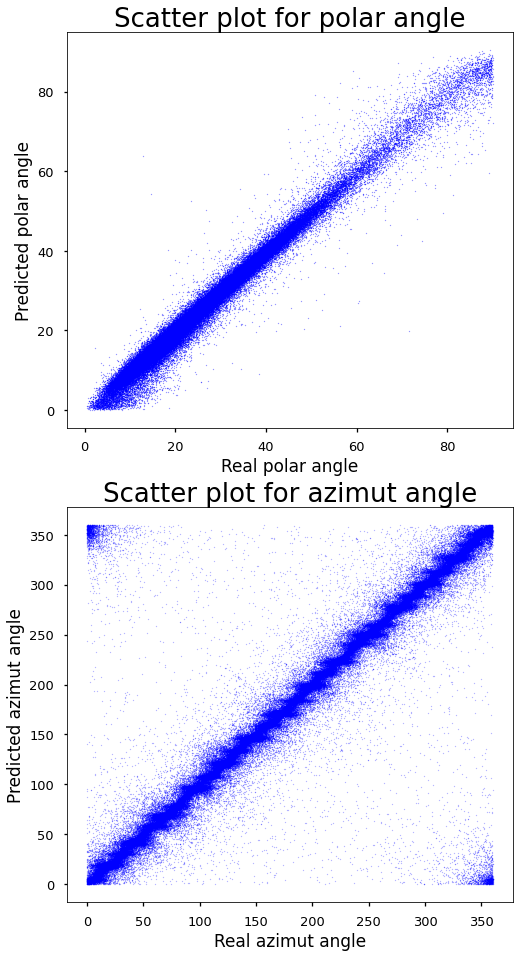

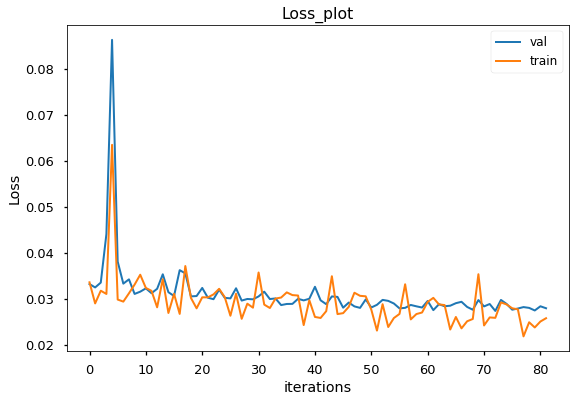

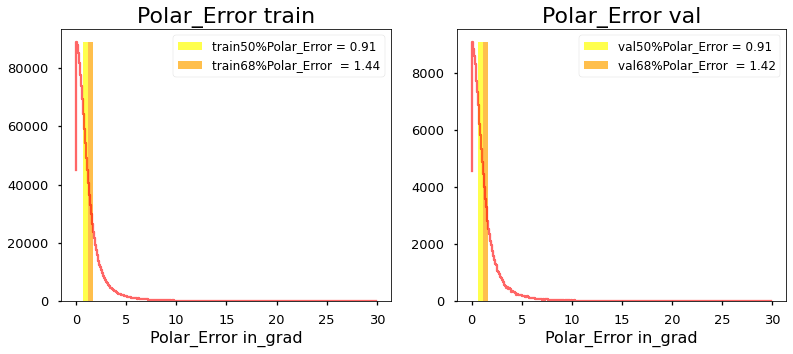

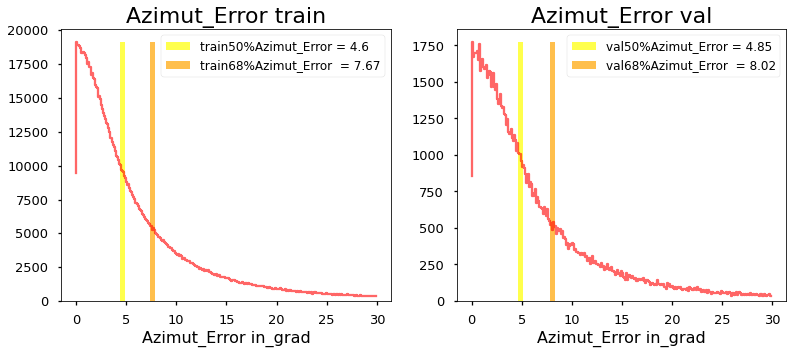

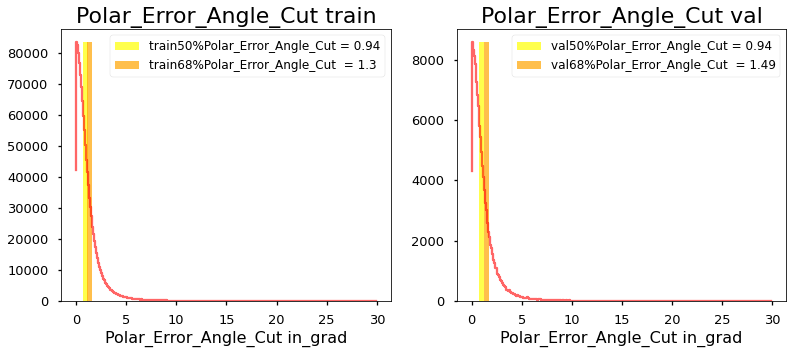

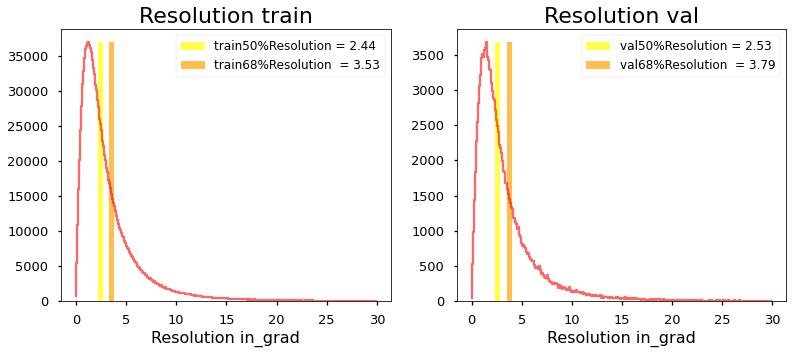

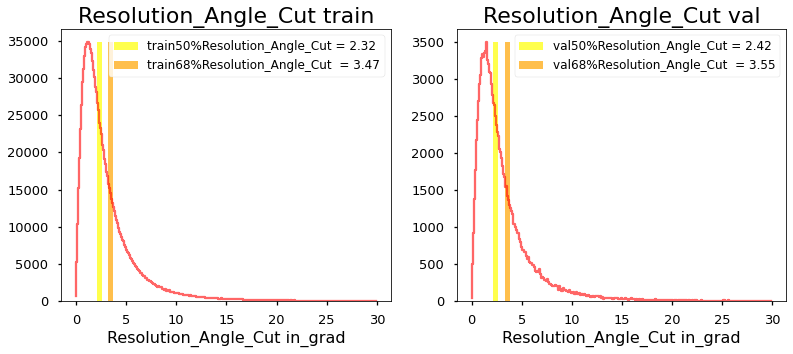

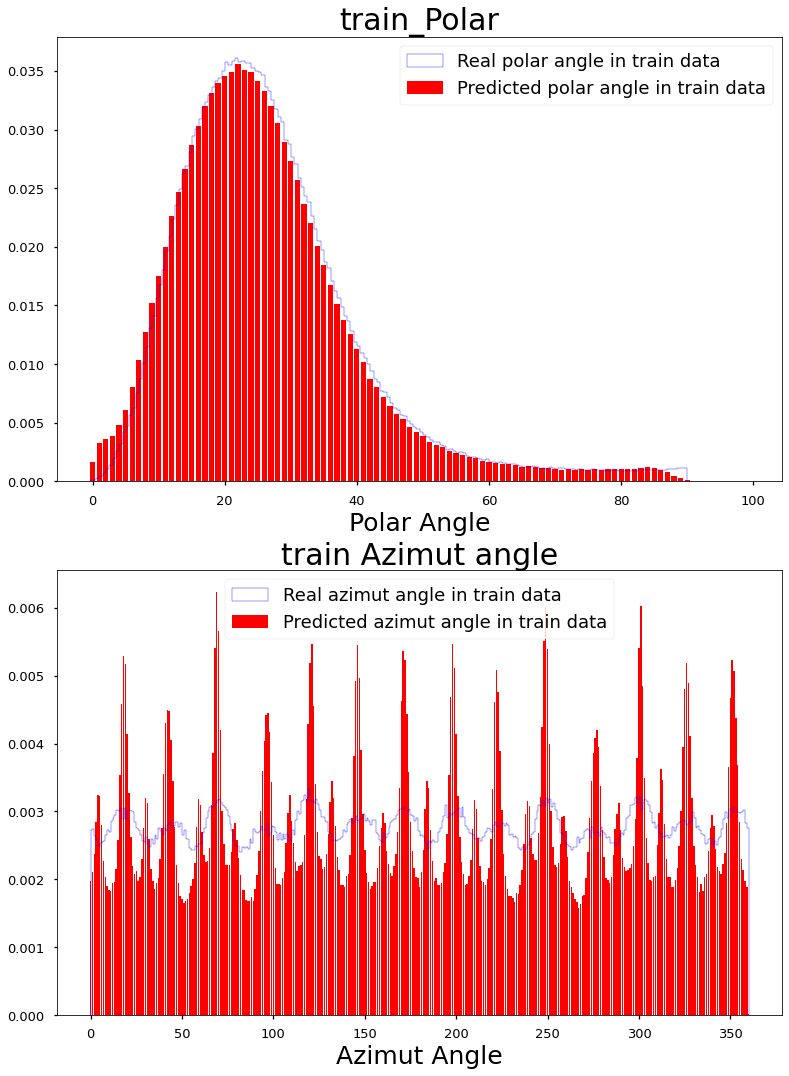

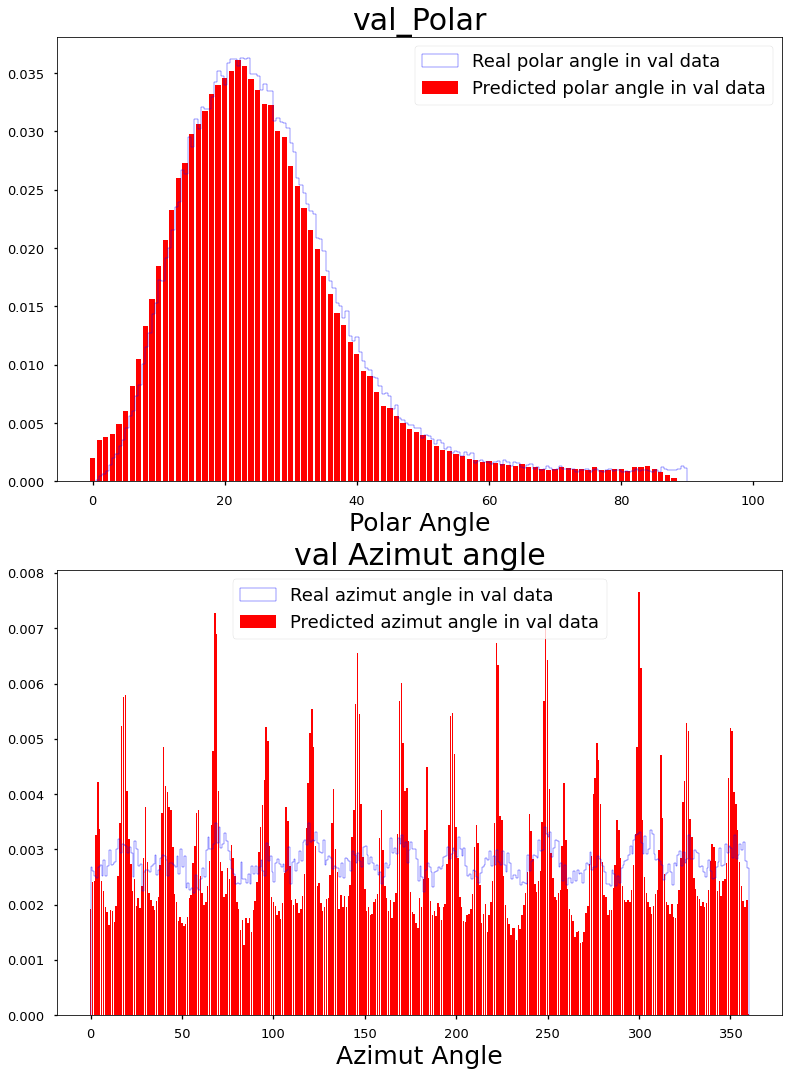

In [7]:
model = much_bigger_net_4.to(device)
learn_rate =6e-3
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1.0) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_direction_128batch",
                                                                       epochs_num=25, batch_size =128)

Indeed Epoch =  1  Indeed Epoch =  2  Indeed Epoch =  3  Indeed Epoch =  4  Indeed Epoch =  5  

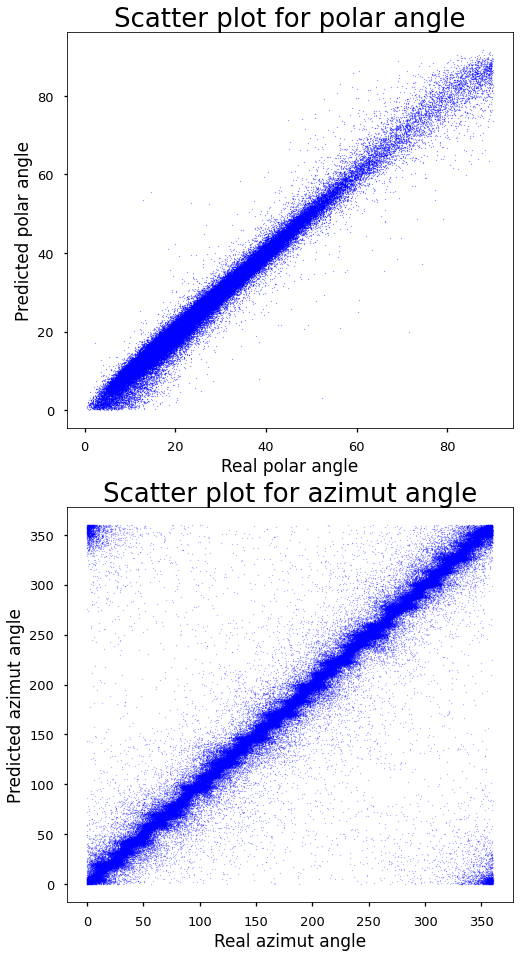

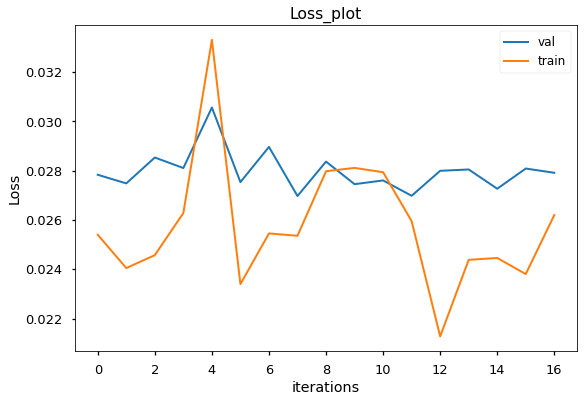

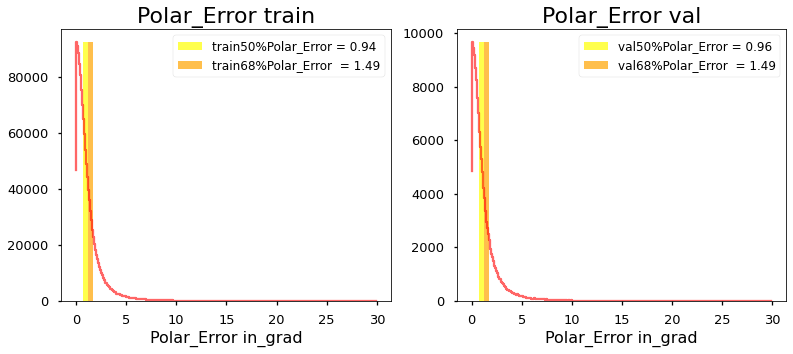

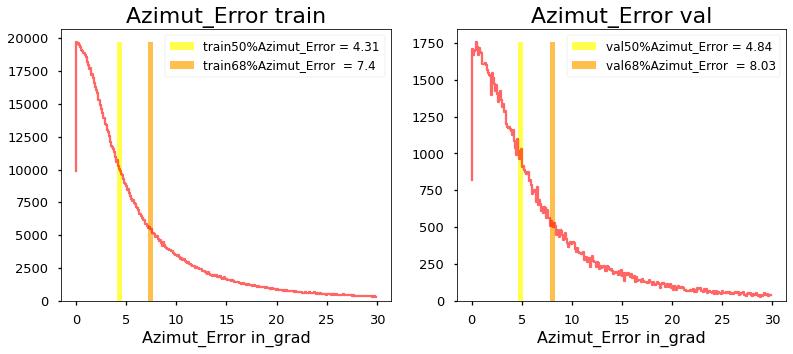

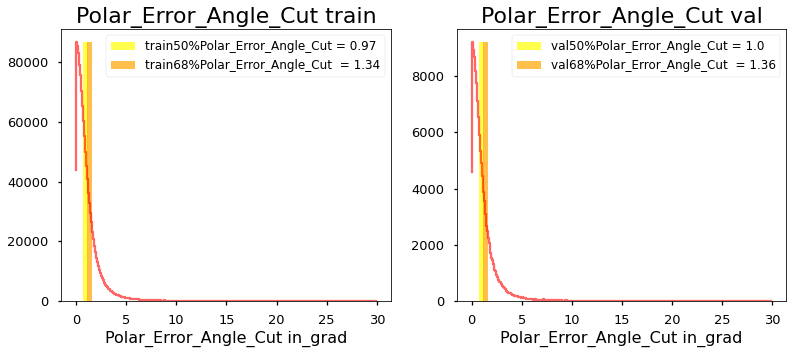

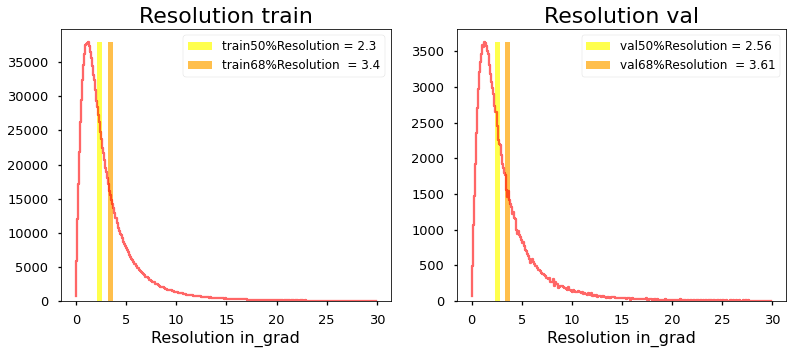

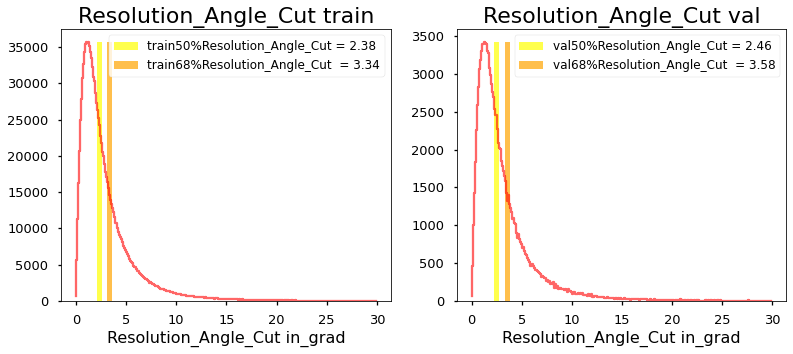

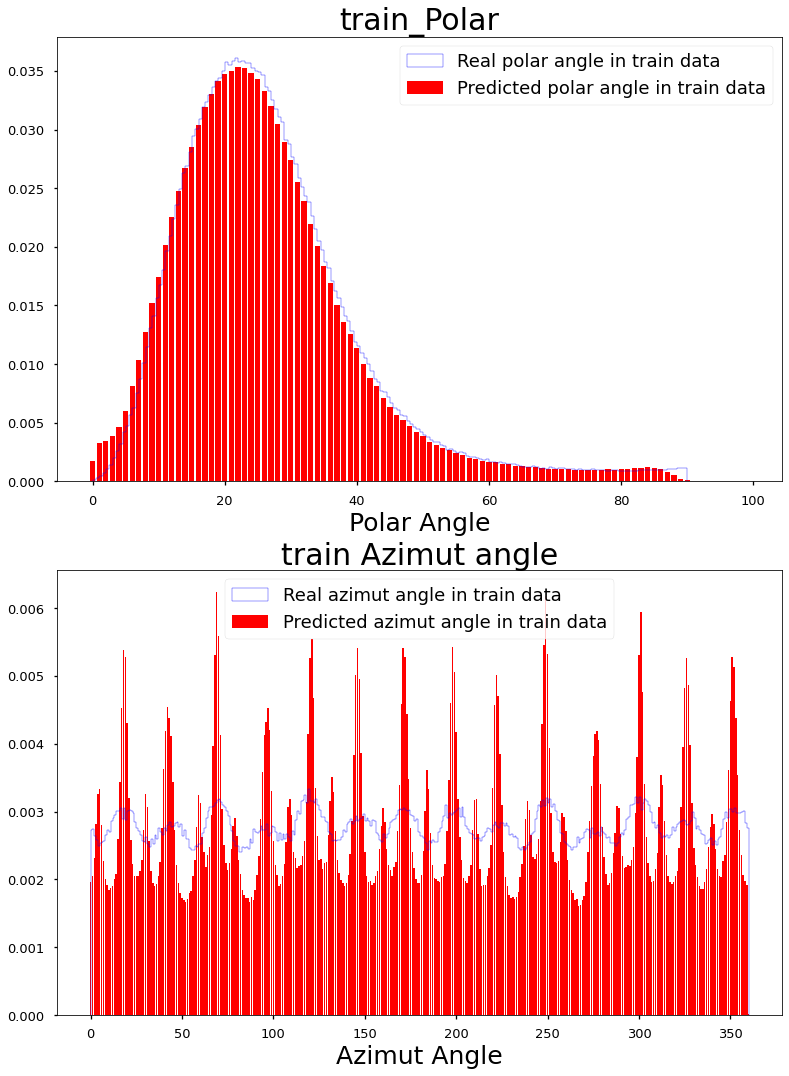

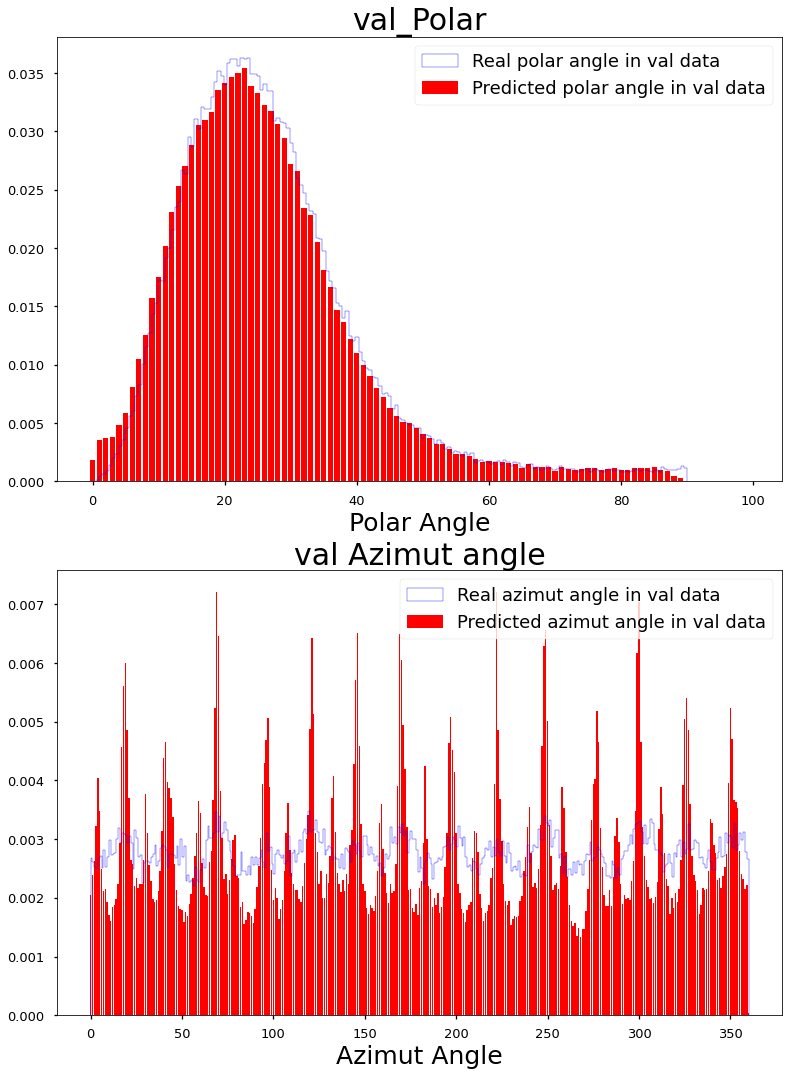

In [8]:
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Res_1D_direction_128batch_30ep",
                                                                       epochs_num=5, batch_size =128)